In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# !wget "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv" -O data-3.csv
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df = pd.read_csv("/kaggle/input/chapter3/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.columns = df.columns.str.lower().str.replace(" ", "_")

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

# fix categorical values
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(" ", "_")

# fix nan values if they are marked with another char    
tc = pd.to_numeric(df.totalcharges, errors='coerce')
print("Missing totalcharges count:",tc.isnull().sum())
df.totalcharges = tc
df.totalcharges = df.totalcharges.fillna(0)

# fix yes/no with 0/1
df.churn = (df.churn == "yes").astype(int)

df.head().T
# df.isnull().sum()

/kaggle/input/chapter3/WA_Fn-UseC_-Telco-Customer-Churn.csv
Missing totalcharges count: 11


,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [2]:
# Setup validation framework
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

df_train = df_train.reset_index(drop="true")
df_val = df_val.reset_index(drop="true")
df_test = df_test.reset_index(drop="true")

y_full_train = df_full_train.churn.values
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_test["churn"]
del df_val["churn"]
del df_train["churn"]
df_train.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')

In [3]:
# EDA Exploritory Data Analysis
numerical_columns = ["monthlycharges", "totalcharges", "tenure"]
categorical_columns = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

df_full_train.churn.value_counts()
df_full_train.churn.value_counts(normalize=True)
df_full_train.churn.mean()
df_full_train.groupby("gender").churn.agg(["mean", "count"])


,mean,count
gender,,
female,0.276824,2796
male,0.263214,2838


In [4]:

female_churn_rate = df_full_train[df_full_train.gender == "female"].churn.mean()
male_churn_rate = df_full_train[df_full_train.gender == "male"].churn.mean()
print("Female churn rate:", female_churn_rate, "; male churn rate:", male_churn_rate )

churn_with_partner = df_full_train[df_full_train.partner == "yes"].churn.mean()
churn_without_partner = df_full_train[df_full_train.partner == "no"].churn.mean()
global_churn = df_full_train.churn.mean()

# Difference:
# global - group <0 = more likely to churn
# global - group >0 = less likely to churn
print("Difference. With partner:",global_churn-churn_with_partner, "; without partner:",global_churn-churn_without_partner)

# Risk:
# group / global <1 = less likely to churn
# group / global >1 = more likely to churn
print("Risk. With partner:",churn_with_partner/global_churn, "; without partner:",churn_without_partner/global_churn)


Female churn rate: 0.27682403433476394 ; male churn rate: 0.2632135306553911
Difference. With partner: 0.06493474245795922 ; without partner: -0.05984095297455855
Risk. With partner: 0.7594724924338315 ; without partner: 1.2216593879412643


In [5]:
# EDA for all columns

from IPython.display import display

def get_diff_and_risk(cat):
    groups = df_full_train.groupby(cat).churn.agg(["mean", "count"])
    groups["diff"] = groups["mean"] - global_churn
    groups["risk"] = groups["mean"] / global_churn
    print(cat)
    display(groups)
    print()
    
for c in categorical_columns:
    get_diff_and_risk(c)

print()

gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980



seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208



partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472



dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651



phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412



multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948



internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201



onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570



onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660



deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480



techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390



streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328



streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182



contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730



paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560



paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


In [6]:
# Feature Importance: Mutual Information
from sklearn import metrics

# how much do we learn about "churn" by observing the "contract" variable:
metrics.mutual_info_score(df_full_train.churn, df_full_train.contract)
# or other way around gives same result:
metrics.mutual_info_score(df_full_train.contract, df_full_train.churn)


# show churn mutual info for each column:
def mutual_info_churn_score(series):
    return metrics.mutual_info_score(series, df_full_train.churn)

mi = df_full_train[categorical_columns].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

In [7]:
#Corelation
churn_correlation = df_full_train[numerical_columns].corrwith(df_full_train.churn)
display(churn_correlation)

churn_below2years = df_full_train[df_full_train.tenure<2].churn.mean()
churn_below2to12years = df_full_train[(df_full_train.tenure>2) & (df_full_train.tenure<12)].churn.mean()
churn_above12years = df_full_train[df_full_train.tenure>12].churn.mean()

print("churn_below2years=", churn_below2years)
print("churn_below2to12years=", churn_below2to12years)
print("churn_above12years=", churn_above12years)


monthlycharges    0.196805
totalcharges     -0.196353
tenure           -0.351885
dtype: float64

churn_below2years= 0.6247464503042597
churn_below2to12years= 0.4059003051881994
churn_above12years= 0.17634908339788277


In [8]:
# Hot Encoding
from sklearn.feature_extraction import DictVectorizer

# train_dicts = df_train[["gender", "contract", "tenure"]].iloc[:100].to_dict(orient='records')
train_dicts = df_train[categorical_columns+numerical_columns].to_dict(orient='records')
dv = DictVectorizer(sparse = False) #sparse =True => enables sparse matrix by compressing 0 values
dv.fit(train_dicts)
dv.transform(train_dicts)  
display("column names:",dv.get_feature_names()) # column names

X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical_columns+numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)


'column names:'

['contract=month-to-month',
 'contract=one_year',
 'contract=two_year',
 'dependents=no',
 'dependents=yes',
 'deviceprotection=no',
 'deviceprotection=no_internet_service',
 'deviceprotection=yes',
 'gender=female',
 'gender=male',
 'internetservice=dsl',
 'internetservice=fiber_optic',
 'internetservice=no',
 'monthlycharges',
 'multiplelines=no',
 'multiplelines=no_phone_service',
 'multiplelines=yes',
 'onlinebackup=no',
 'onlinebackup=no_internet_service',
 'onlinebackup=yes',
 'onlinesecurity=no',
 'onlinesecurity=no_internet_service',
 'onlinesecurity=yes',
 'paperlessbilling=no',
 'paperlessbilling=yes',
 'partner=no',
 'partner=yes',
 'paymentmethod=bank_transfer_(automatic)',
 'paymentmethod=credit_card_(automatic)',
 'paymentmethod=electronic_check',
 'paymentmethod=mailed_check',
 'phoneservice=no',
 'phoneservice=yes',
 'seniorcitizen',
 'streamingmovies=no',
 'streamingmovies=no_internet_service',
 'streamingmovies=yes',
 'streamingtv=no',
 'streamingtv=no_internet_servic

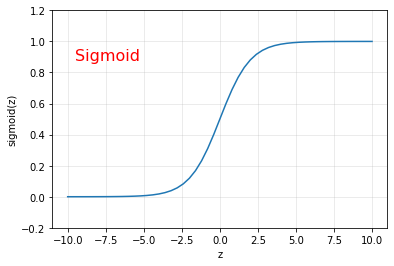

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ])

In [9]:
#Sigmoid

import matplotlib.pyplot as plt
import seaborn as sns


def sigmoid(z):
    return 1/(1+np.exp(-z))

z = np.linspace(-10, 10, 51)

sigmoidZ = sigmoid(z)

plt.plot(z, sigmoidZ)
plt.ylabel('sigmoid(z)')
plt.xlabel('z')
plt.grid(True, alpha=0.3)
plt.text(-9.5, .88, r'Sigmoid', fontsize=16, color='red')
plt.ylim(-0.2, 1.2)
plt.show()
z

In [10]:
#Logistic regretion
from sklearn import linear_model

model = linear_model.LogisticRegression()

model.fit(X_train, y_train)
weights = model.coef_[0].round(3) # weights
model.intercept_ # bias, w0

weights_with_featureNames = dict(zip(dv.get_feature_names(), weights))
display(weights_with_featureNames)

model.predict(X_val) #hard predictions:  y= {0,1}
proba = model.predict_proba(X_val) #hard predictions:  y= 0->1. Returns probablility as [% for 0,% for 1]
y_pred_val = proba[:,1]  #take column 1

churn_decision = (y_pred_val >= 0.5)
customers_that_will_leave = df_val[churn_decision].customerid  # the people who will churn

#check average accuracy on y_val
(churn_decision.astype(int) == y_val).mean()

df_pred = pd.DataFrame()
df_pred["probability"] = y_pred_val
df_pred["prediction"] = churn_decision.astype(int)
df_pred["actual"] = y_val
df_pred["prediction_correct"] = df_pred.prediction == df_pred.actual
print("Accuracy % on y_val:",df_pred.prediction_correct.mean())


{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.258,
 'multiplelines=no_phone_service': 0.141,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.063,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.266,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.124,
 'partner=no': -0.166,
 'partner=yes': 0.058,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.07,
 

Accuracy % on y_val: 0.8034066713981547


In [11]:
# Small Model Interpretation

small = ["contract", "tenure", "monthlycharges"]
dicts_train_small = df_train[small].to_dict(orient="records")
dicts_val_small = df_val[small].to_dict(orient="records")

dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

dv_small.get_feature_names()  # => ['contract=month-to-month', 'contract=one_year', 'contract=two_year', 'monthlycharges', 'tenure']

X_train_small = dv_small.transform(dicts_train_small)
model_small = linear_model.LogisticRegression()
model_small.fit(X_train_small, y_train)
w0 = model_small.intercept_[0] # bias, w0
w = model_small.coef_[0].round(3) # weights

weights_with_names = dict(zip(dv_small.get_feature_names(), w))
print("w0 =", w0, "weights_with_names: ", weights_with_names)


w0 = -2.476775658265233 weights_with_names:  {'contract=month-to-month': 0.97, 'contract=one_year': -0.025, 'contract=two_year': -0.949, 'monthlycharges': 0.027, 'tenure': -0.036}


In [12]:
#Using the model

def train_model(dataFrame, y):
    dicts = dataFrame[categorical_columns+numerical_columns].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    dv.fit(dicts)
    X = dv.transform(dicts)

    model = linear_model.LogisticRegression()
    model.fit(X, y)
    return model

model_full_train = train_model(df_full_train,y_full_train)

w0 = model_full_train.intercept_[0] # bias, w0
w = model_full_train.coef_[0].round(3) # weigh

#test:
dicts_test = df_test[categorical_columns+numerical_columns].to_dict(orient="records")
X_test = dv.transform(dicts_test)
y_pred = model_full_train.predict_proba(X_test)[:,1]
churn_decision = (y_pred >= 0.5)
print("Model accuracy based on test data:", (churn_decision == y_test).mean())


#example: Prediction on 1 customer
customer = df_test.iloc[10]
X_customer = dv.transform([customer])
y_customer = model_full_train.predict_proba(X_customer)[0,1]
customer_churn = (y_customer>=0.5)
print("Probability of Customer1 to churn:",customer_churn,",Actual churn:", y_test[10])

Model accuracy based on test data: 0.815471965933286
Probability of Customer1 to churn: False ,Actual churn: 0
